In [1]:
from qutip import basis, tensor, Qobj, Bloch, fidelity, visualization
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Define the QWP matrix
def qwp_matrix(theta):
    theta = np.radians(theta)
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    Q = np.array([
        [1, 0],
        [0, 1j]
    ])
    return R.T @ Q @ R

# Define the HWP matrix
def hwp_matrix(theta):
    theta = np.radians(theta)
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    H = np.array([
        [1, 0],
        [0, -1]
    ])
    return R.T @ H @ R

In [3]:
# Bell state generation
H = basis(2, 0)
V = basis(2, 1)
HH = tensor(H, H)
VV = tensor(V, V)

# Bell state with arbitrary phase
phi = np.pi/2
bell_state_with_phase = (HH + np.exp(1j * phi) * VV).unit()
bell_state_with_phase

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678+0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.70710678j]]

In [4]:
# Objective function
def phase_error(params, initial_state):
    q1_angle, h_angle, q2_angle = params
    Q1 = qwp_matrix(q1_angle)
    H = hwp_matrix(h_angle)
    Q2 = qwp_matrix(q2_angle)
    total_transform = Q2 @ H @ Q1

    HH_coeff = initial_state.full()[0][0]
    VV_coeff = initial_state.full()[3][0]
    input_vector = np.array([HH_coeff, VV_coeff])
    output_vector = total_transform @ input_vector

    relative_phase = np.angle(output_vector[1]) - np.angle(output_vector[0])
    magnitude_diff = abs(abs(output_vector[0]) - abs(output_vector[1]))
    return abs(relative_phase) + magnitude_diff

# Initial guess and optimization
initial_guess = [45, 90, 45]
result = minimize(
    phase_error, initial_guess, args=(bell_state_with_phase),
    bounds=[(0, 90), (0, 180), (0, 90)], method='L-BFGS-B',
    options={'maxiter': 1000, 'ftol': 1e-10}
)
q1_angle_opt, h_angle_opt, q2_angle_opt = result.x

In [5]:
# Apply wave plates
def apply_waveplates(state, q1_angle, h_angle, q2_angle):
    Q1 = qwp_matrix(q1_angle)
    H = hwp_matrix(h_angle)
    Q2 = qwp_matrix(q2_angle)
    total_transform = Q2 @ H @ Q1

    HH_coeff = state.full()[0][0]
    VV_coeff = state.full()[3][0]
    input_vector = np.array([HH_coeff, VV_coeff])
    output_vector = total_transform @ input_vector

    corrected_state = tensor(basis(2, 0), basis(2, 0)) * output_vector[0] + \
                      tensor(basis(2, 1), basis(2, 1)) * output_vector[1]
    return corrected_state.unit()

bell_state_corrected = apply_waveplates(bell_state_with_phase, q1_angle_opt, h_angle_opt, q2_angle_opt)


In [6]:
# Normalize to remove global phase
global_phase = np.angle(bell_state_corrected.full()[0][0])  # Phase of |HH> component
bell_state_corrected = bell_state_corrected * np.exp(-1j * global_phase)

# Fancy Output
print("=" * 60)
print("QWP-HWP-QWP Phase Correction for Bell State".center(60))
print("=" * 60)
print(f"Optimized Angles: QWP1 = {q1_angle_opt:.2f}°, HWP = {h_angle_opt:.2f}°, QWP2 = {q2_angle_opt:.2f}°")
print("\nInitial Bell State with Phase:")
print(bell_state_with_phase)
print("\nCorrected Bell State (Global Phase Removed):")
print(bell_state_corrected)

        QWP-HWP-QWP Phase Correction for Bell State         
Optimized Angles: QWP1 = 0.00°, HWP = 180.00°, QWP2 = 45.00°

Initial Bell State with Phase:
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678+0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.70710678j]]

Corrected Bell State (Global Phase Removed):
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678+0.00000000e+00j]
 [0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j]
 [0.70710678+9.31056343e-11j]]


In [7]:
# Verify corrected phase
HH_coeff = bell_state_corrected.full()[0][0]
VV_coeff = bell_state_corrected.full()[3][0]
corrected_phase = np.angle(VV_coeff) - np.angle(HH_coeff)
print(f"\nCorrected Relative Phase: {np.degrees(corrected_phase):.4f}°")
print("=" * 60)


Corrected Relative Phase: 0.0000°


<Figure size 1440x1440 with 0 Axes>

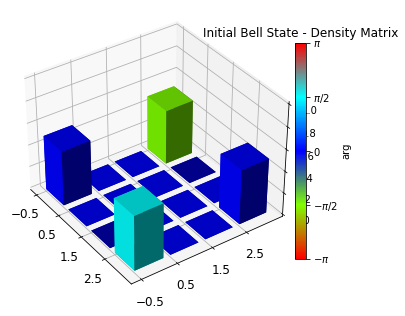

<Figure size 1440x1440 with 0 Axes>

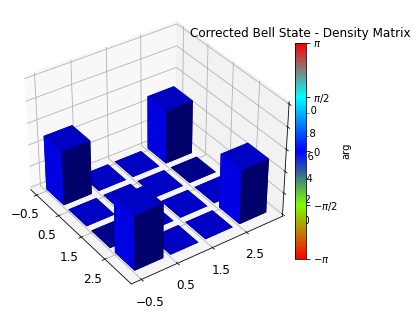

In [8]:
def plot_density_matrix(state, title):
    rho = state.proj()
    fig = plt.figure(figsize=(20, 20))
    visualization.matrix_histogram_complex(rho)
    plt.title(title)
    plt.show()

plot_density_matrix(bell_state_with_phase, "Initial Bell State - Density Matrix")
plot_density_matrix(bell_state_corrected, "Corrected Bell State - Density Matrix")
